In [69]:
notebook7_url = "http://localhost:8888/tree?token=0632b0fc07210bebdbbefff741405fed38571a050a79c40f"
default_result_path = None
close_on_fail = False
transition_timeout = 10000
default_delay = 200

In [70]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpxp_zx_f6'

# Sidestickies E2E Test - File Browser Toggle on Notebook 7

- Test that the sidestickies toggle button works in the file browser
- Verify that notebook tag widgets appear on .ipynb files when toggled on

In [71]:
import re
import asyncio
import importlib

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *

from scripts import sidestickies

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path, delay=default_delay)

('20251103-081101',
 '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpmwyyeo5e')

## Open Notebook 7 and wait for it to load

Start epoch: 1762125061.769352 seconds


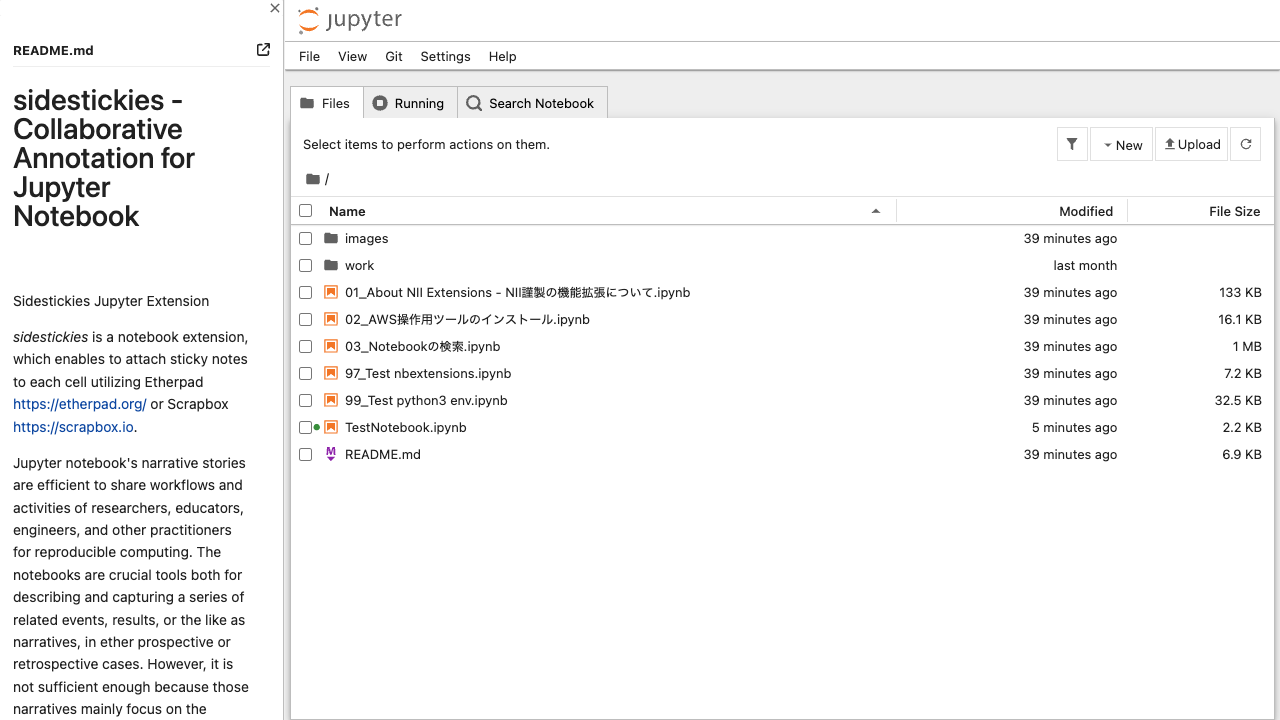

In [72]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    await page.goto(notebook7_url)

    # Wait for Notebook 7 file browser to load
    await expect(page.locator('.jp-DirListing')).to_be_visible(timeout=transition_timeout)

    # Wait for the work directory to be visible
    await expect(sidestickies.get_file_browser_item_locator(page, 'work')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Remove existing test notebook if it exists

Start epoch: 1762125063.6057348 seconds


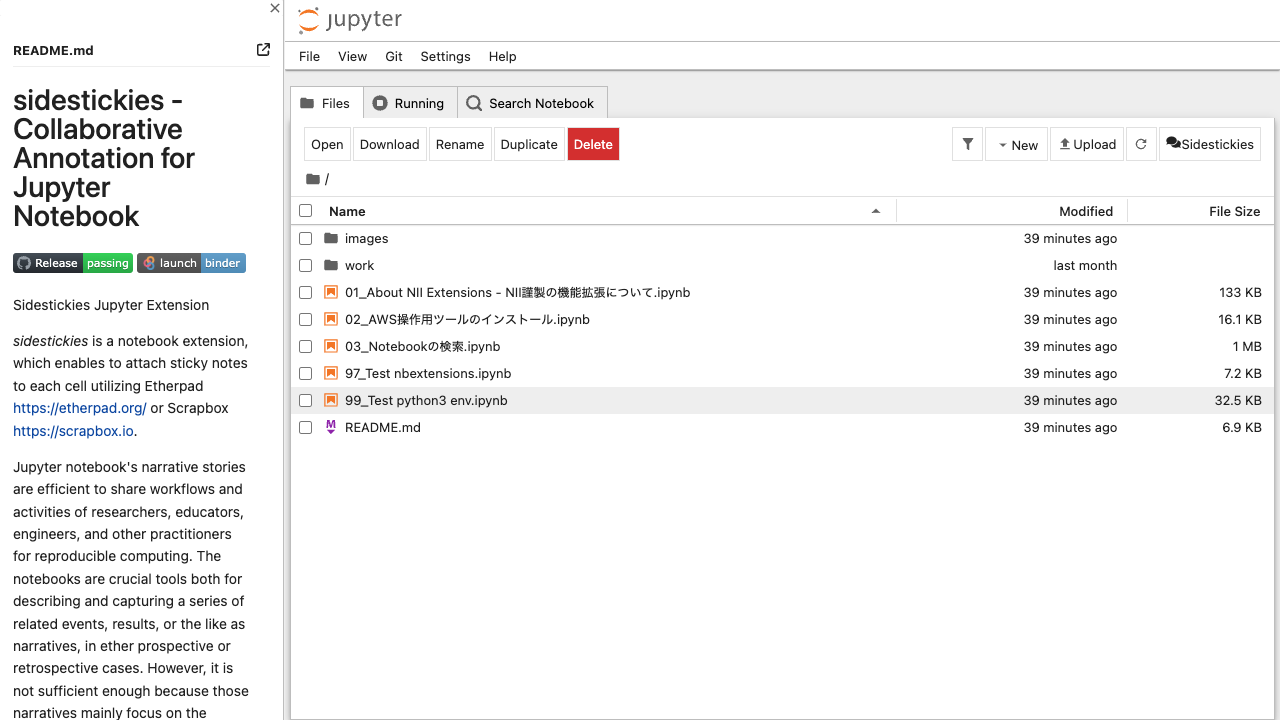

In [73]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

test_filename = 'TestNotebook.ipynb'

async def _step(page):
    test_filename_locator = sidestickies.get_file_browser_item_locator(page, test_filename)
    
    if not await test_filename_locator.is_visible():
        print(f"Test notebook '{test_filename}' does not exist. Creating a new one.")
        return
    
    await test_filename_locator.click(button='right')
    await page.locator('//*[@data-command="filebrowser:delete" and @role="menuitem"]').click()

    await page.locator('//*[contains(@class, "jp-Dialog-buttonLabel") and text()="Delete"]').click()

    await expect(test_filename_locator).not_to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## Create a test notebook in the file browser

Start epoch: 1762125064.9349718 seconds
Notebook opened in new tab: http://localhost:8888/notebooks/Untitled.ipynb


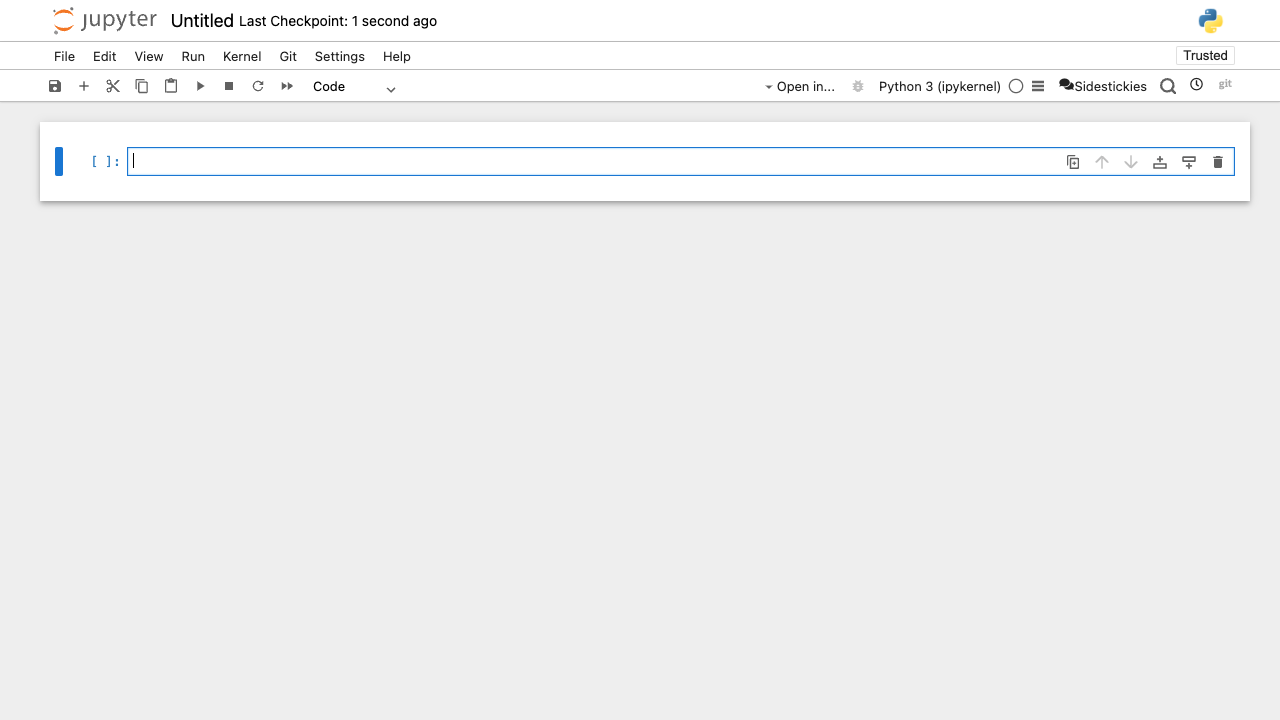

In [74]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    # Wait for a new window (popup) to open when creating a new notebook
    popup_future = page.wait_for_event('popup')
    
    # Click on "New" menu and select "Python 3 (ipykernel)"
    await page.locator('//*[contains(@class, "lm-MenuBar-itemLabel") and text()="New"]').click()
    await page.locator('ul[role="menu"] >> text=Python 3 (ipykernel)').click()
    
    # Wait for popup to open
    popup = await popup_future
    
    # Wait for the notebook to load in the new tab
    await expect(popup.locator('.jp-Notebook')).to_be_visible(timeout=transition_timeout)
    
    print(f"Notebook opened in new tab: {popup.url}")
    
    return popup

await run_pw(_step)

## Fill the first cell with some content

Start epoch: 1762125066.47762 seconds


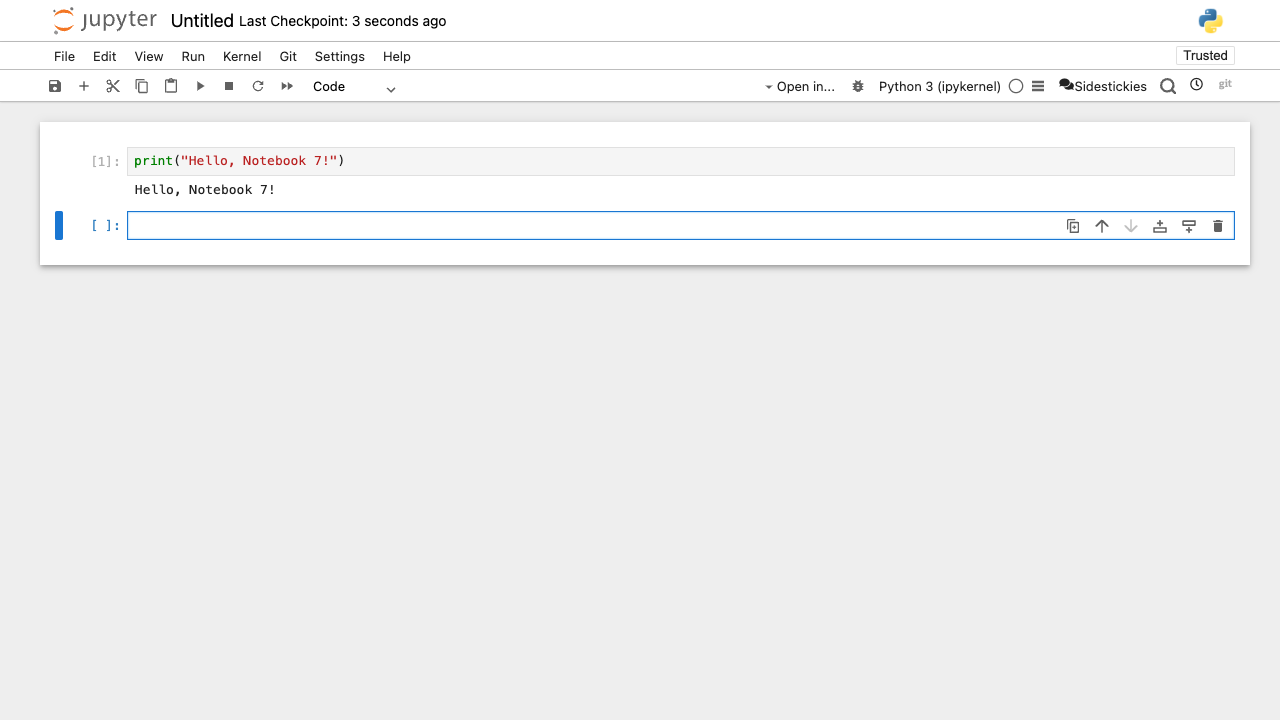

In [75]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    cell = page.locator('.jp-Cell-inputArea .cm-content').first
    await sidestickies.input_code_in_cell(page, cell, 'print("Hello, Notebook 7!")')

    # Wait for the new cell to be added
    await expect(page.locator('.jp-Cell')).to_have_count(2, timeout=transition_timeout)

await run_pw(_step)

## Save and rename the notebook

Start epoch: 1762125068.992998 seconds


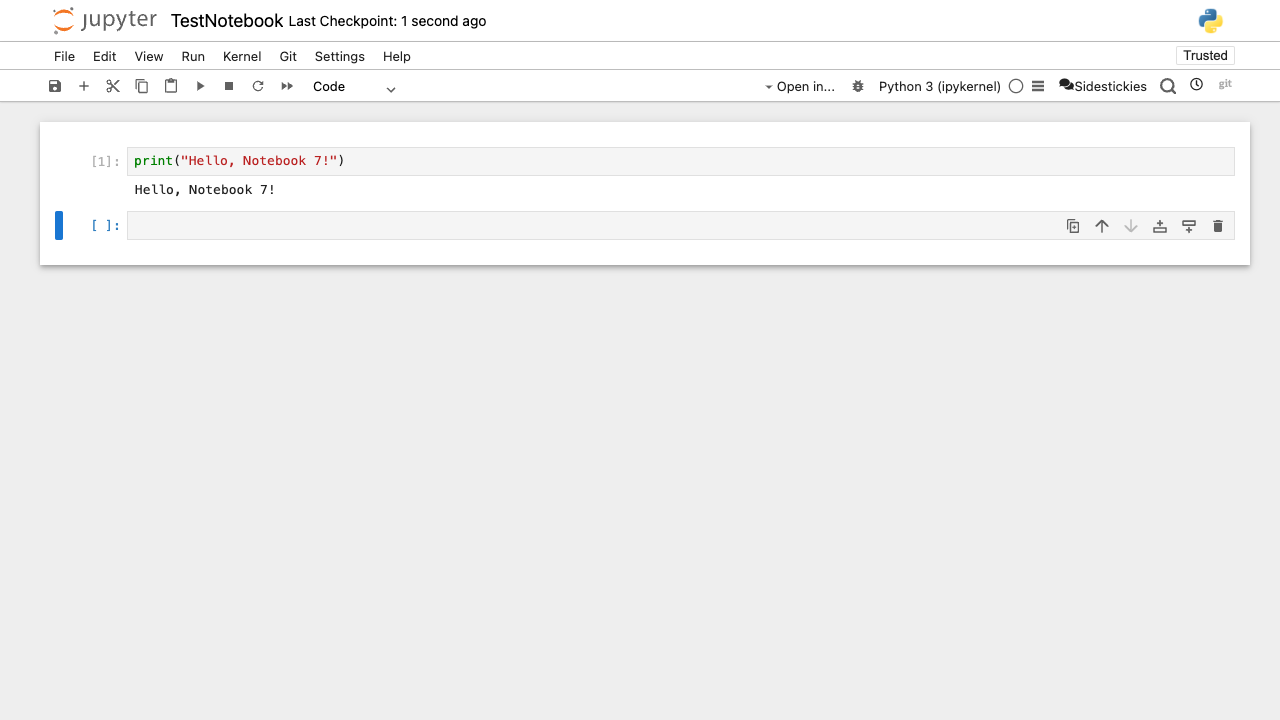

In [76]:
async def _step(page):
    # Click save button
    await page.locator('[data-command="docmanager:save"]').click()
    
    # Wait for save to complete
    await asyncio.sleep(1)

    # Rename the notebook
    await page.locator('//*[contains(@class, "lm-MenuBar-itemLabel") and text()="File"]').click()
    await page.locator('[data-command="application:rename"]').click()

    # Wait for rename dialog
    await page.locator('//*[contains(@class, "jp-new-name-title")]/..//input').fill(test_filename)
    await page.locator('//*[@aria-label="Rename File"]').click()
    
    # Wait for save to complete
    await asyncio.sleep(1)

await run_pw(_step)

## Verify sidestickies toggle button exists in notebook toolbar

Start epoch: 1762125071.4816089 seconds
Sidestickies toggle button found in notebook toolbar


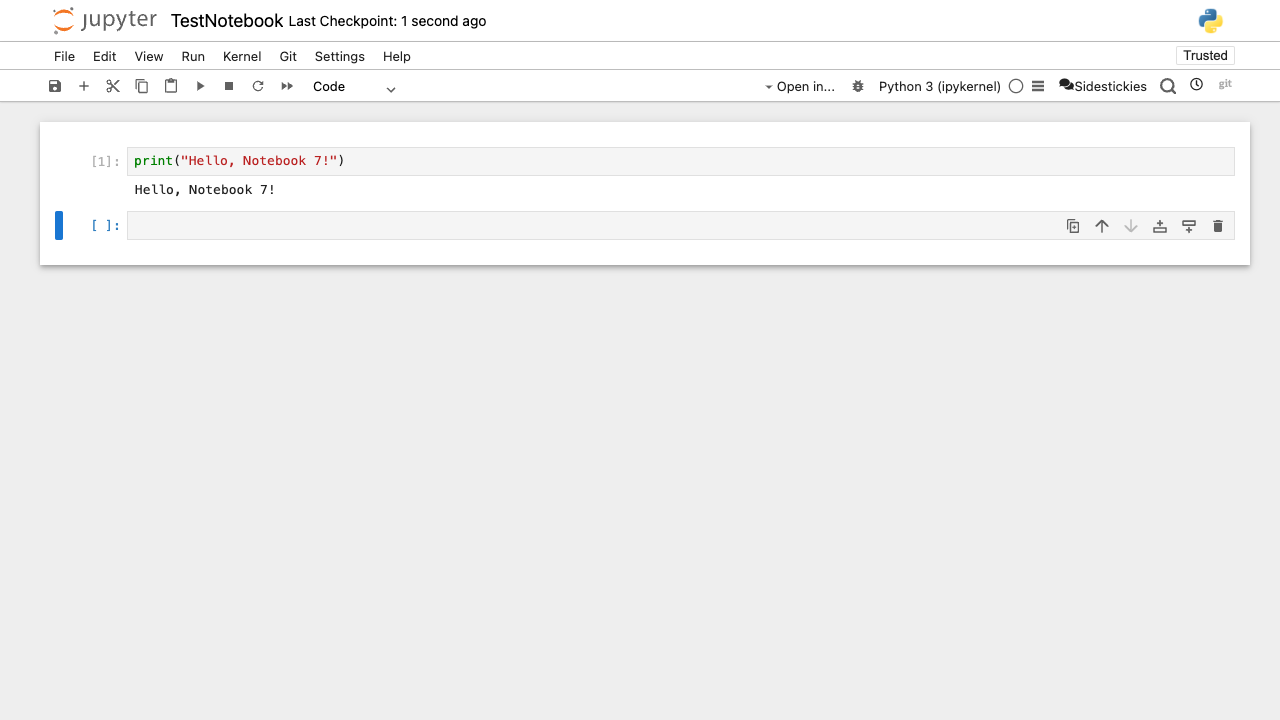

In [77]:
async def _step(page):
    # Look for the sidestickies toggle button in the notebook toolbar
    toggle_button = page.locator('.jp-NotebookPanel .sidestickies-comment-toggle')
    await expect(toggle_button).to_be_visible(timeout=transition_timeout)
    
    print("Sidestickies toggle button found in notebook toolbar")

await run_pw(_step)

## Click the toggle button to enable sidestickies

Start epoch: 1762125071.776509 seconds
Sidestickies enabled in notebook panel


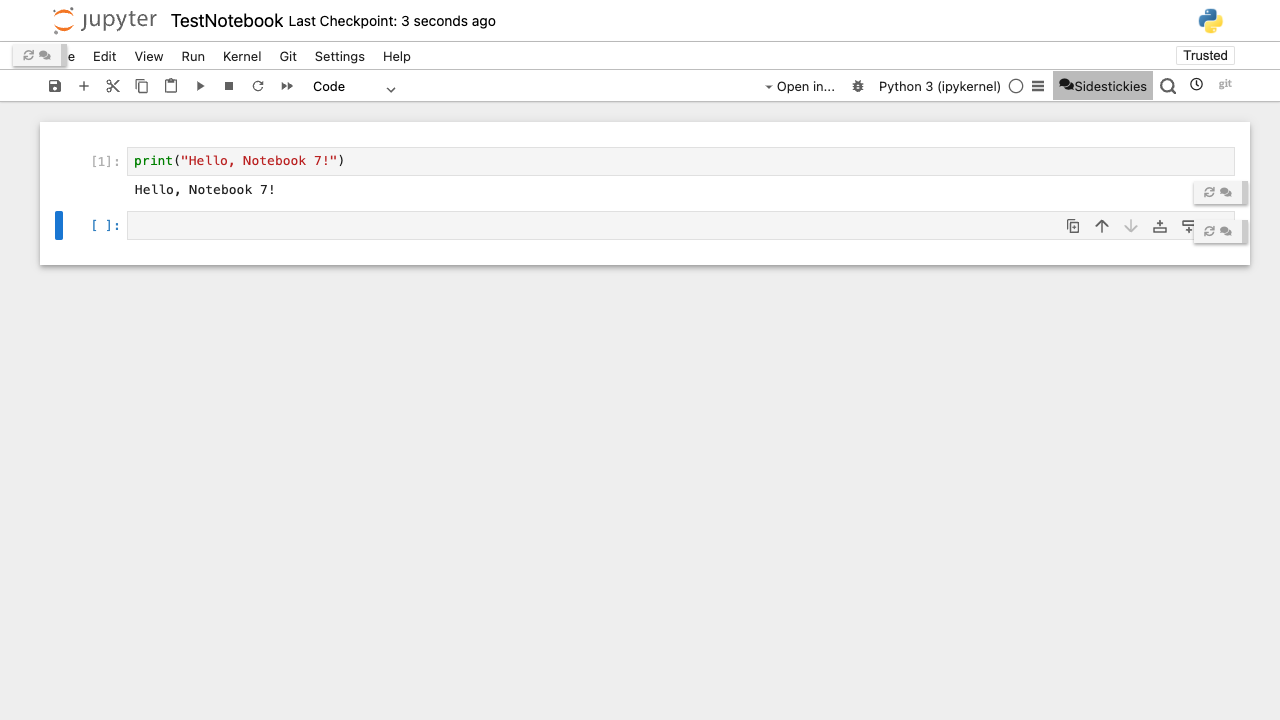

In [78]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    toggle_button = page.locator('.jp-NotebookPanel .sidestickies-comment-toggle').locator('..')
    await expect(toggle_button).to_be_attached(timeout=transition_timeout)

    attr = await toggle_button.get_attribute('class')
    if 'sidestickies-comment-visible' in attr:
        print("Sidestickies already enabled in notebook toolbar")
        return

    # Click the toggle button
    await toggle_button.click()
    await asyncio.sleep(0.5)
    
    # Verify the button is now in active state
    await expect(toggle_button).to_have_class(re.compile(r'.*sidestickies-comment-visible.*'), timeout=transition_timeout)
    
    print("Sidestickies enabled in notebook panel")

await run_pw(_step)

## Verify that cell tag widgets appear on cells in the notebook

Start epoch: 1762125072.610044 seconds
Notebook tag widgets display correctly on cells


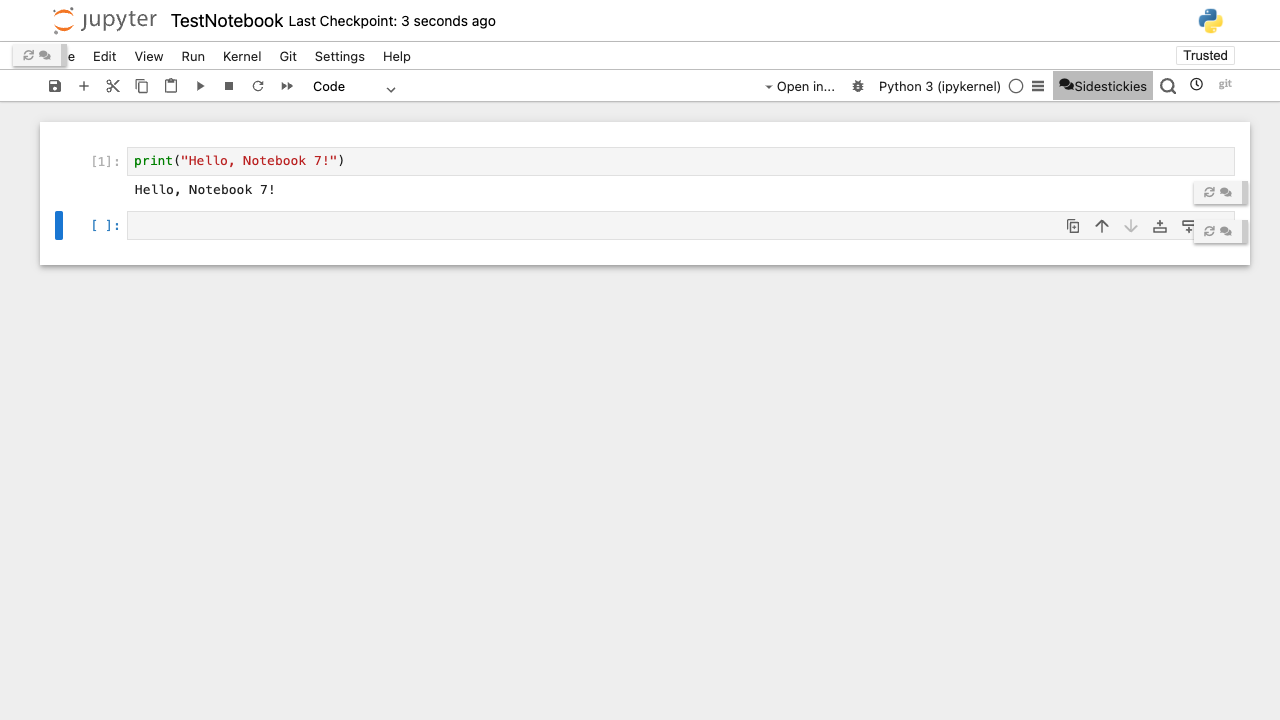

In [79]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    note_locator = page.locator('.jp-Cell').first.locator('.nbtags-widget-root .nbtags-tag')
    await expect(note_locator).to_be_visible(timeout=transition_timeout)
    
    # Verify the tag has expected structure (refresh icon and comments icon)
    await expect(note_locator.locator('.fa-refresh')).to_be_visible()
    await expect(note_locator.locator('.fa-comments')).to_be_visible()

    print("Notebook tag widgets display correctly on cells")

await run_pw(_step)

## Open new sticky note for the first cell

Start epoch: 1762125072.908347 seconds


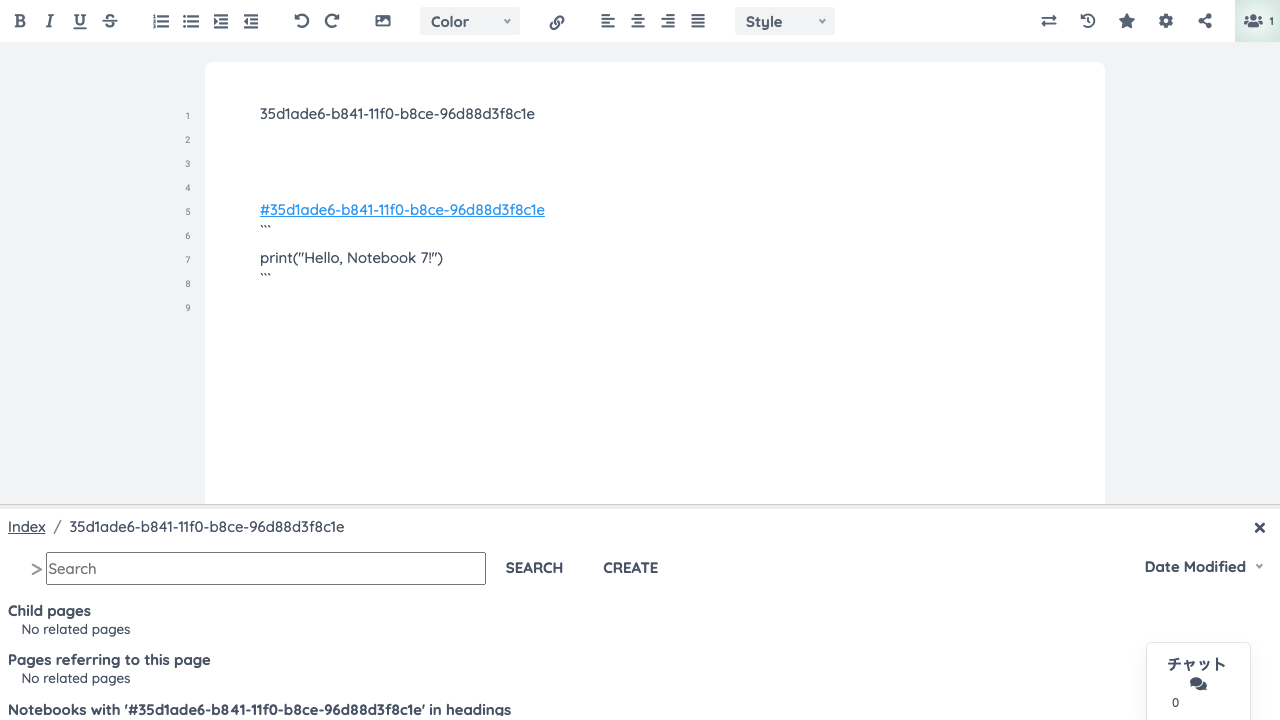

In [80]:
import re

async def _step(page):
    # Wait for a new window to open
    popup_future = page.wait_for_event('popup')
    await page.locator('.jp-Cell').first.locator('.nbtags-widget-root .fa-comments').click()
    popup = await popup_future

    await expect(popup.locator('//iframe[@name="ace_outer"]')).to_be_visible(timeout=transition_timeout)

    return popup

await run_pw(_step)

## Change the title of the sticky note pad

Start epoch: 1762125074.074142 seconds


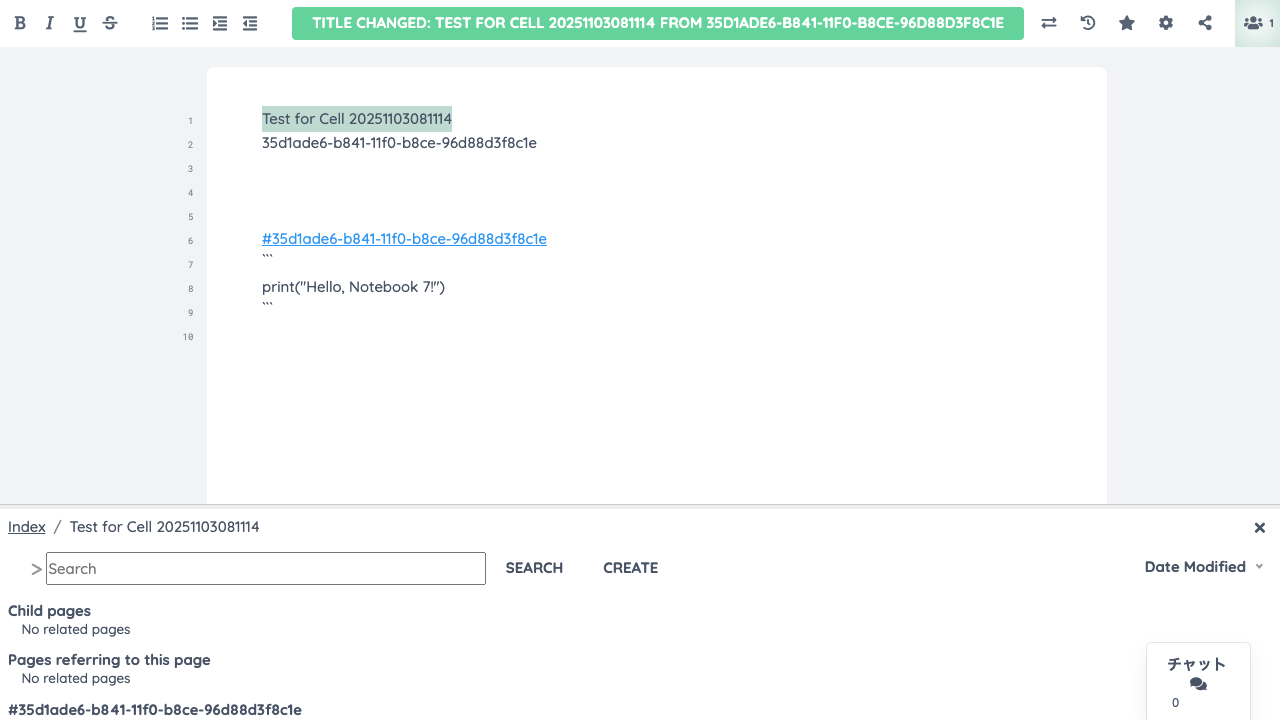

In [81]:
from datetime import datetime
import re

async def extract_ace_inner_docbody(page):
    iframe_locator = page.frame_locator('iframe[name="ace_outer"]').frame_locator('iframe[name="ace_inner"]')
    await expect(iframe_locator.locator('#innerdocbody')).to_be_visible(timeout=transition_timeout)
    return iframe_locator.locator('#innerdocbody')

cell_pad_title = f"Test for Cell {datetime.now().strftime('%Y%m%d%H%M%S')}"

async def _step(page):
    inner_docbody = await extract_ace_inner_docbody(page)
    await inner_docbody.focus()

    await inner_docbody.type(cell_pad_title, delay=100)
    await inner_docbody.press("Enter")

    await page.wait_for_load_state('networkidle')
    await asyncio.sleep(1)  # Wait a moment to ensure the title change is processed
    await expect(page).to_have_title(re.compile(f"^{cell_pad_title}"), timeout=transition_timeout)

await run_pw(_step)

## Close the pad window and refresh the sticky note widget

Start epoch: 1762125079.062485 seconds


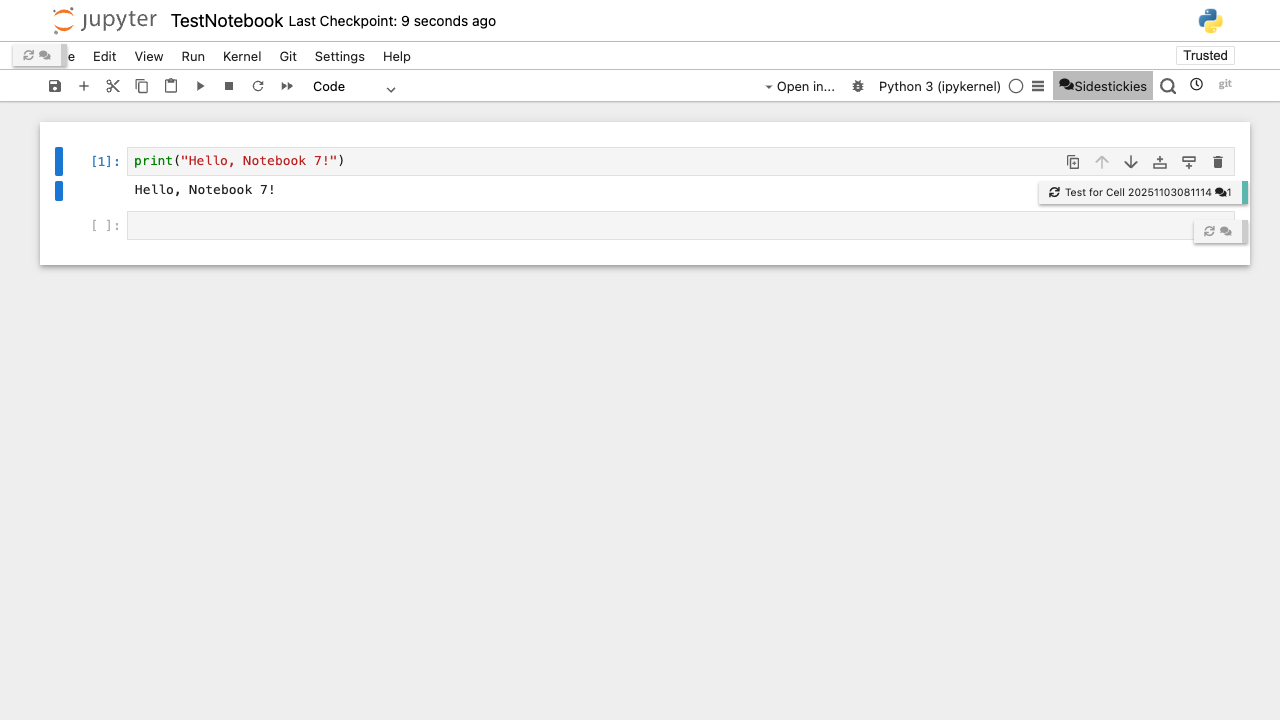

In [82]:
async def _step(page):
    cell = page.locator('.jp-Cell').first.locator('.nbtags-widget-root')
    await cell.locator('.fa-refresh').click()
    
    await expect(cell.locator('.item_name')).to_have_text(re.compile(cell_pad_title), timeout=transition_timeout)

await close_latest_page()
await run_pw(_step)

## Add a Markdown cell with a heading

Start epoch: 1762125079.534496 seconds
Added a Markdown cell with heading


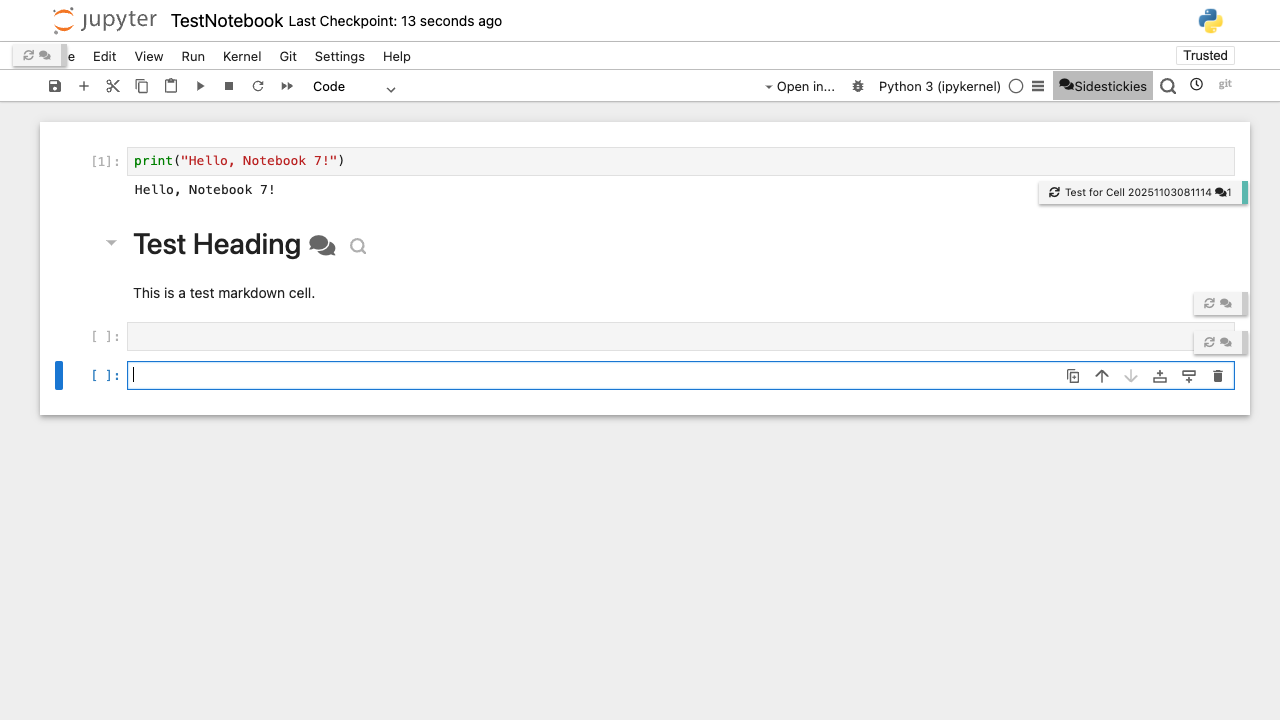

In [83]:
async def _step(page):
    # Get initial cell count
    initial_cells = page.locator('.jp-Cell')
    initial_count = await initial_cells.count()
    
    # Insert a new cell below the first cell
    await page.locator('.jp-Cell').first.click()
    await page.keyboard.press('Escape')  # Ensure command mode
    await page.keyboard.press('b')  # Insert cell below
    
    # Wait for the new cell to be created
    await expect(initial_cells).to_have_count(initial_count + 1, timeout=transition_timeout)
    
    # Change the cell type to Markdown (the newly created cell should be active)
    await asyncio.sleep(0.5)  # Wait a moment to ensure the cell is active
    await page.keyboard.press('m')
    
    # Get the active/selected markdown cell
    markdown_cell = page.locator('.jp-Cell.jp-mod-active.jp-MarkdownCell')
    await expect(markdown_cell).to_be_visible(timeout=transition_timeout)
    
    # Enter the cell and add markdown content with a heading
    await markdown_cell.locator('.cm-content').click()
    await sidestickies.input_code_in_cell(page, markdown_cell.locator('.cm-content'), '# Test Heading\n\nThis is a test markdown cell.')
    
    # Render the markdown cell
    await page.keyboard.press('Shift+Enter')
    
    # Wait for markdown to be rendered
    await expect(page.locator('.jp-MarkdownCell .jp-MarkdownOutput')).to_be_visible(timeout=transition_timeout)
    
    print("Added a Markdown cell with heading")

await run_pw(_step)

## Click on the heading text to create a sticky note

Start epoch: 1762125082.745744 seconds
Sticky note opened by clicking markdown heading


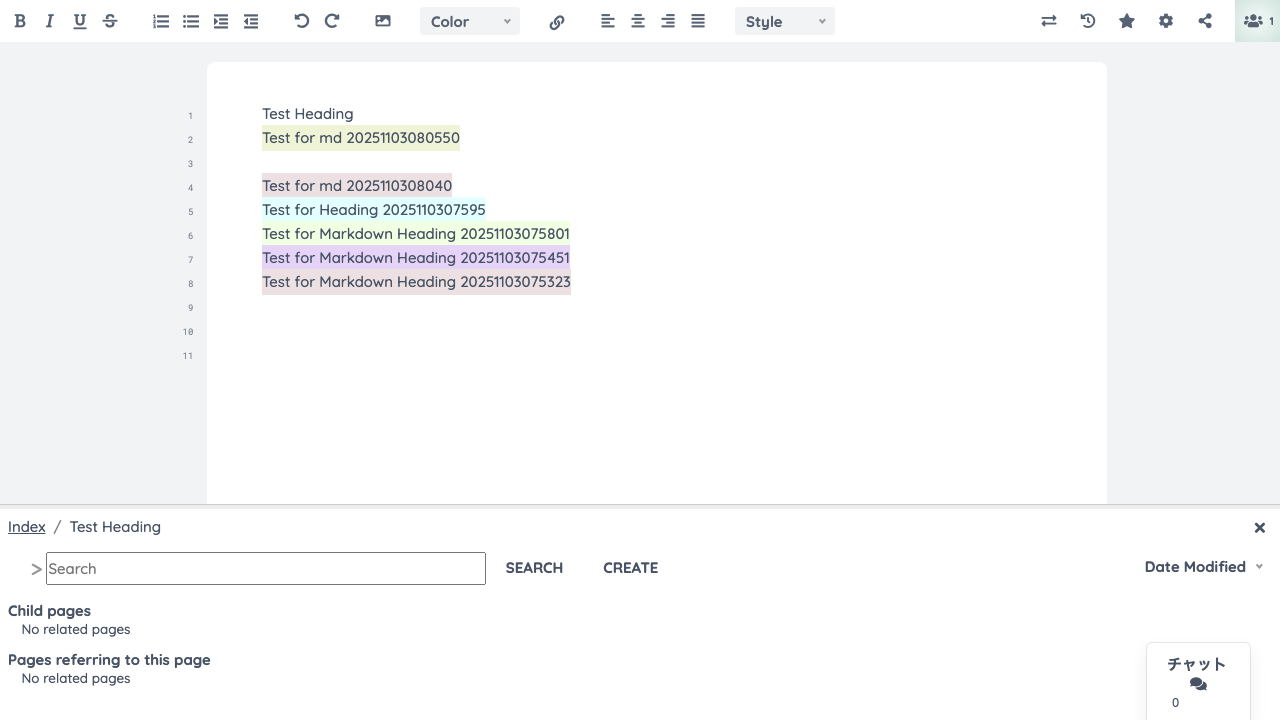

In [84]:
async def _step(page):
    # Find the markdown cell with rendered output
    markdown_cell = page.locator('.jp-MarkdownCell:has(.jp-MarkdownOutput)')
    
    # Wait for a new window to open when clicking the heading
    popup_future = page.wait_for_event('popup')
    
    # Click on the heading text in the rendered markdown
    await markdown_cell.locator('.jp-MarkdownOutput h1:has-text("Test Heading")').locator('.fa-comments').click()
    
    popup = await popup_future
    await expect(popup.locator('//iframe[@name="ace_outer"]')).to_be_visible(timeout=transition_timeout)
    
    print("Sticky note opened by clicking markdown heading")
    
    return popup

await run_pw(_step)

## Add a message to the markdown heading sticky note

Start epoch: 1762125083.757809 seconds


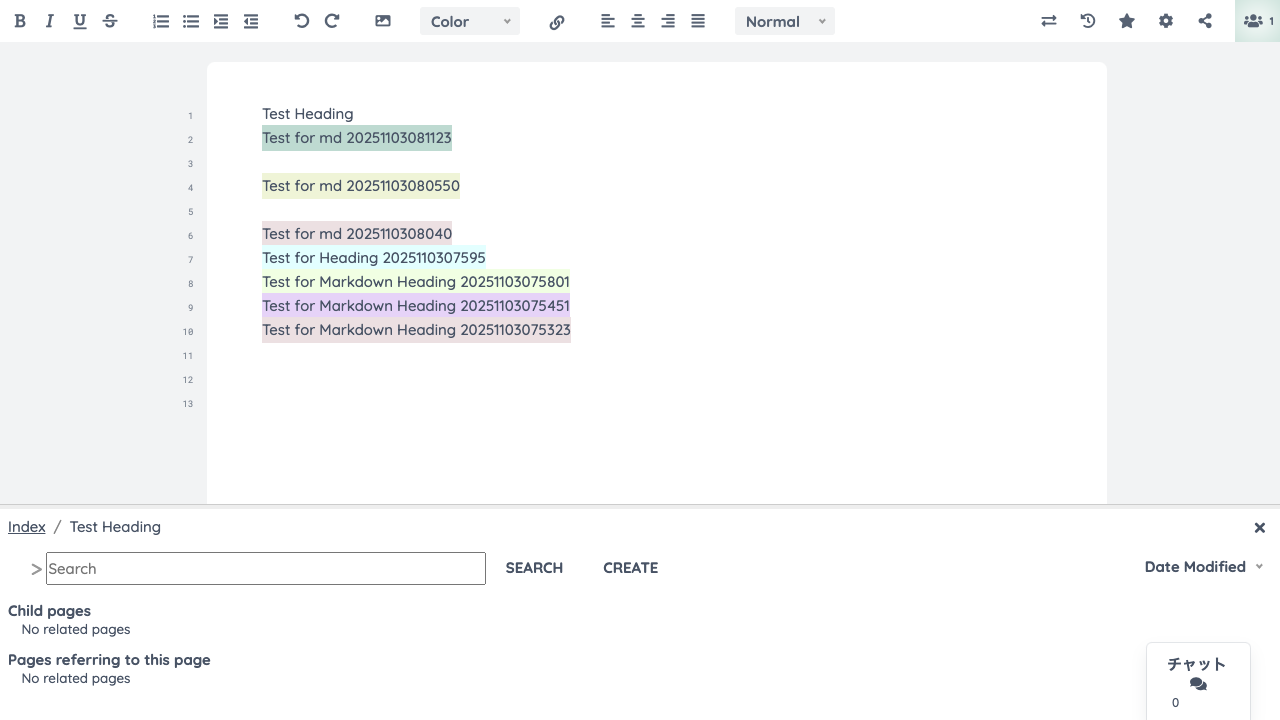

In [85]:
markdown_heading_content = f"Test for md {datetime.now().strftime('%Y%m%d%H%M%S')}"

async def _step(page):
    inner_docbody = await extract_ace_inner_docbody(page)
    await inner_docbody.focus()

    await inner_docbody.press("End")
    await inner_docbody.press("Enter")
    await inner_docbody.type(markdown_heading_content, delay=100)
    await inner_docbody.press("Enter")

    await page.wait_for_load_state('networkidle')
    await asyncio.sleep(1)  # Wait a moment to ensure the content change is processed

await run_pw(_step)

## Close the pad and verify the sticky note appears on the markdown cell

Start epoch: 1762125087.8941529 seconds
Test for md 20251103081123
Sticky note appears on markdown cell with correct title


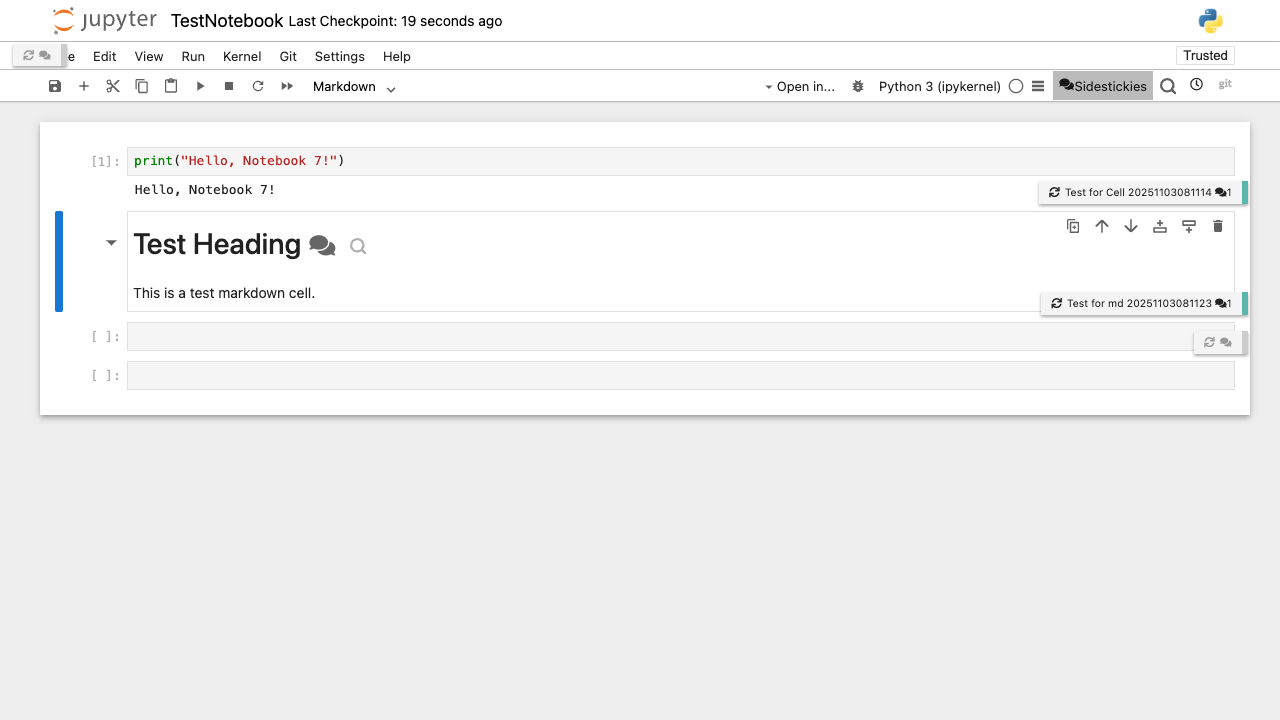

In [86]:
async def _step(page):
    # Find the markdown cell with rendered output
    markdown_cell = page.locator('.jp-MarkdownCell:has(.jp-MarkdownOutput)')
    note_locator = markdown_cell.locator('.nbtags-widget-root .nbtags-tag')
    await note_locator.locator('.fa-refresh').click()
    
    # Verify sticky note widget appears on the markdown cell
    await expect(note_locator).to_be_visible(timeout=transition_timeout)
    
    # Verify the sticky note shows the title we set
    print(markdown_heading_content)
    await expect(note_locator.locator('.item_name')).to_have_text(re.compile(markdown_heading_content), timeout=transition_timeout)
    
    print("Sticky note appears on markdown cell with correct title")

await close_latest_page()
await run_pw(_step)

## Close the notebook tab

Start epoch: 1762125088.352295 seconds
Closed notebook, returned to file browser


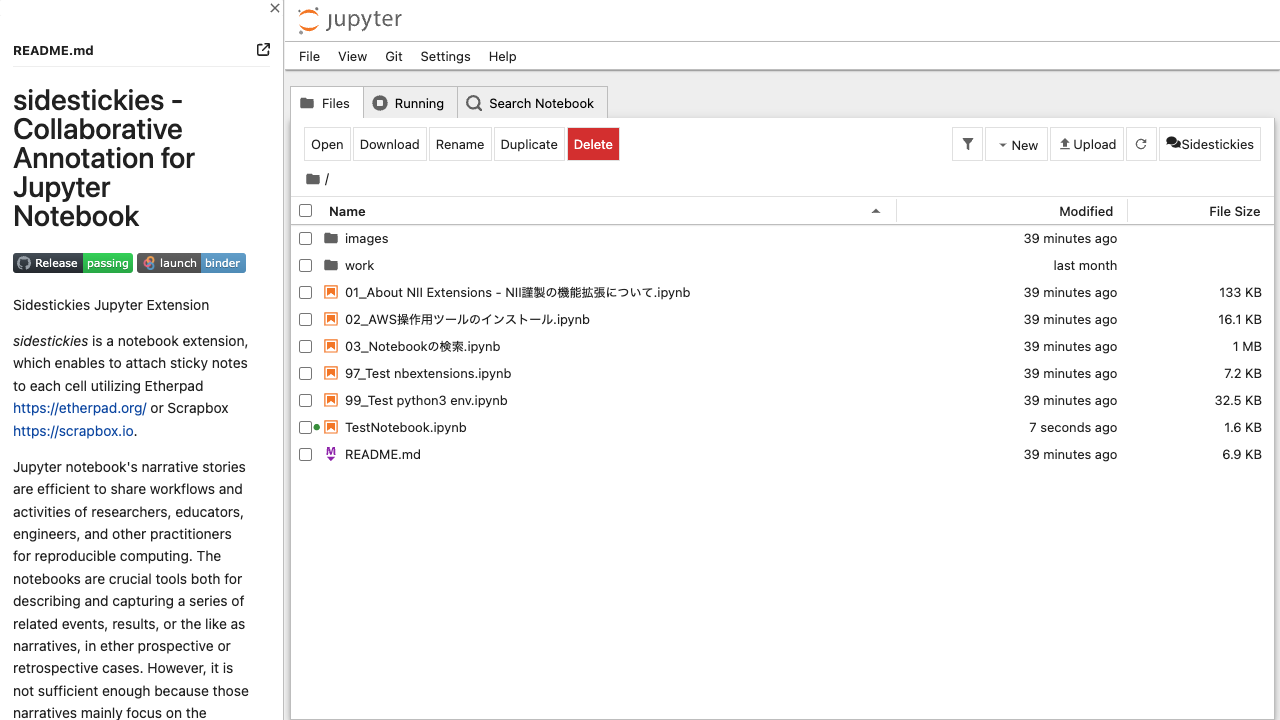

In [87]:
async def _step(page):
    print("Closed notebook, returned to file browser")

await close_latest_page()
await run_pw(_step)

## Verify sidestickies toggle button exists in file browser toolbar

Start epoch: 1762125088.6589272 seconds
Sidestickies toggle button found in file browser


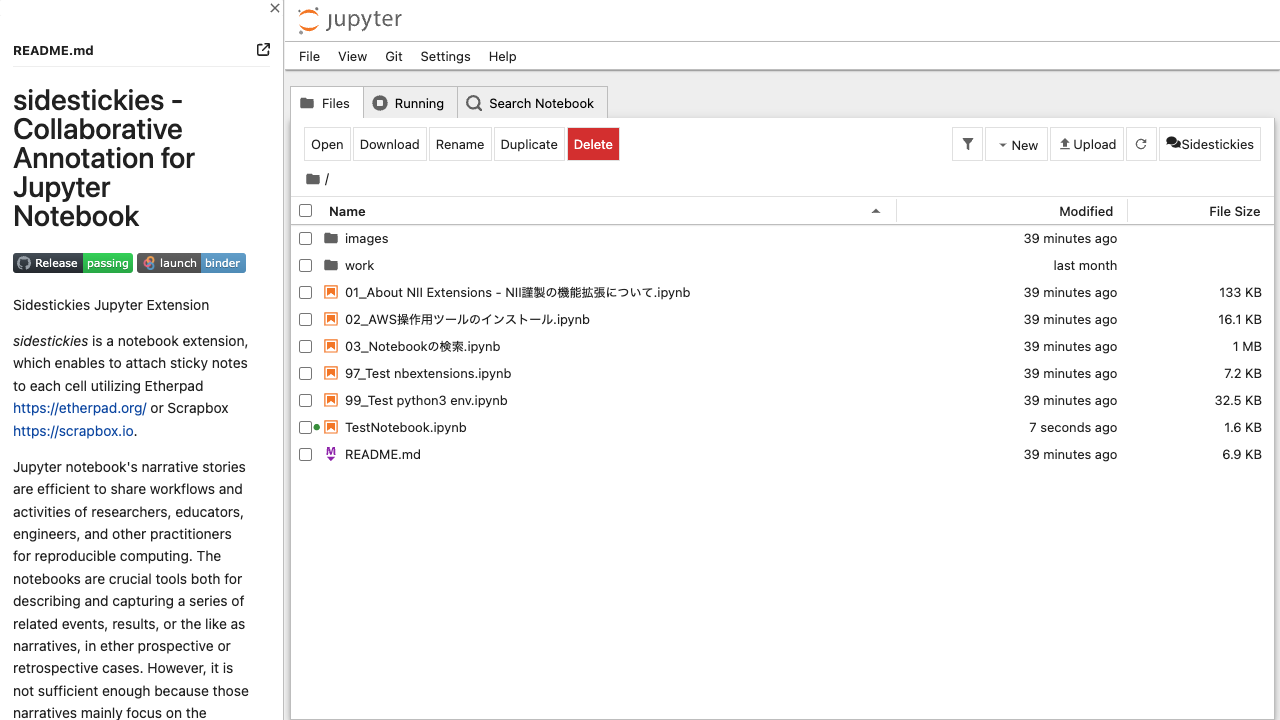

In [88]:
async def _step(page):
    # Look for the sidestickies toggle button in the file browser toolbar
    toggle_button = page.locator('.jp-FileBrowser .sidestickies-comment-toggle')
    await expect(toggle_button).to_be_visible(timeout=transition_timeout)
    
    print("Sidestickies toggle button found in file browser")

await run_pw(_step)

## Click the toggle button to enable sidestickies

Start epoch: 1762125088.956249 seconds
Sidestickies enabled in file browser


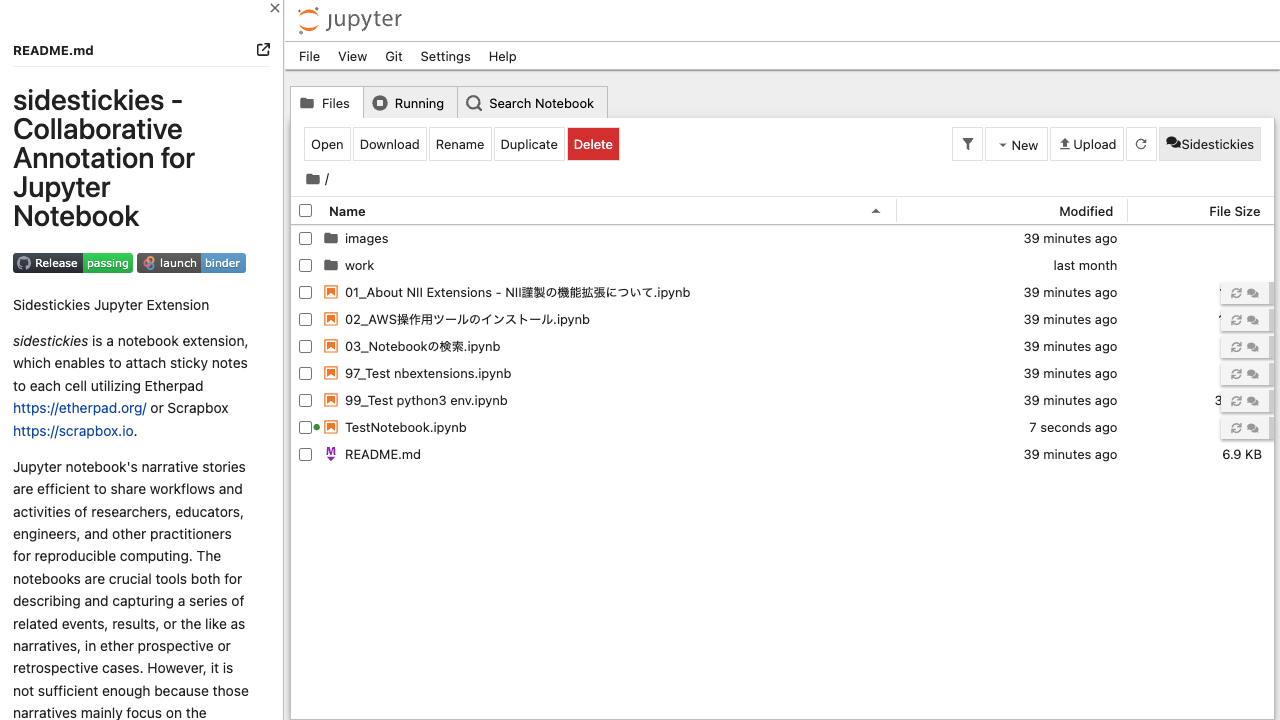

In [89]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    toggle_button = sidestickies.get_file_browser_sidestickies_button_locator(page)
    await expect(toggle_button).to_be_attached(timeout=transition_timeout)

    attr = await toggle_button.get_attribute('class')
    if 'sidestickies-comment-visible' in attr:
        print("Sidestickies already enabled in file browser")
        return

    # Click the toggle button
    await toggle_button.click()
    await asyncio.sleep(0.5)
    
    # Verify the button is now in active state
    await expect(toggle_button).to_have_class(re.compile(r'.*sidestickies-comment-visible.*'), timeout=transition_timeout)
    
    print("Sidestickies enabled in file browser")

await run_pw(_step)

## Verify that notebook tag widgets appear on .ipynb files

Start epoch: 1762125089.789739 seconds
Notebook tag widgets display correctly on .ipynb files


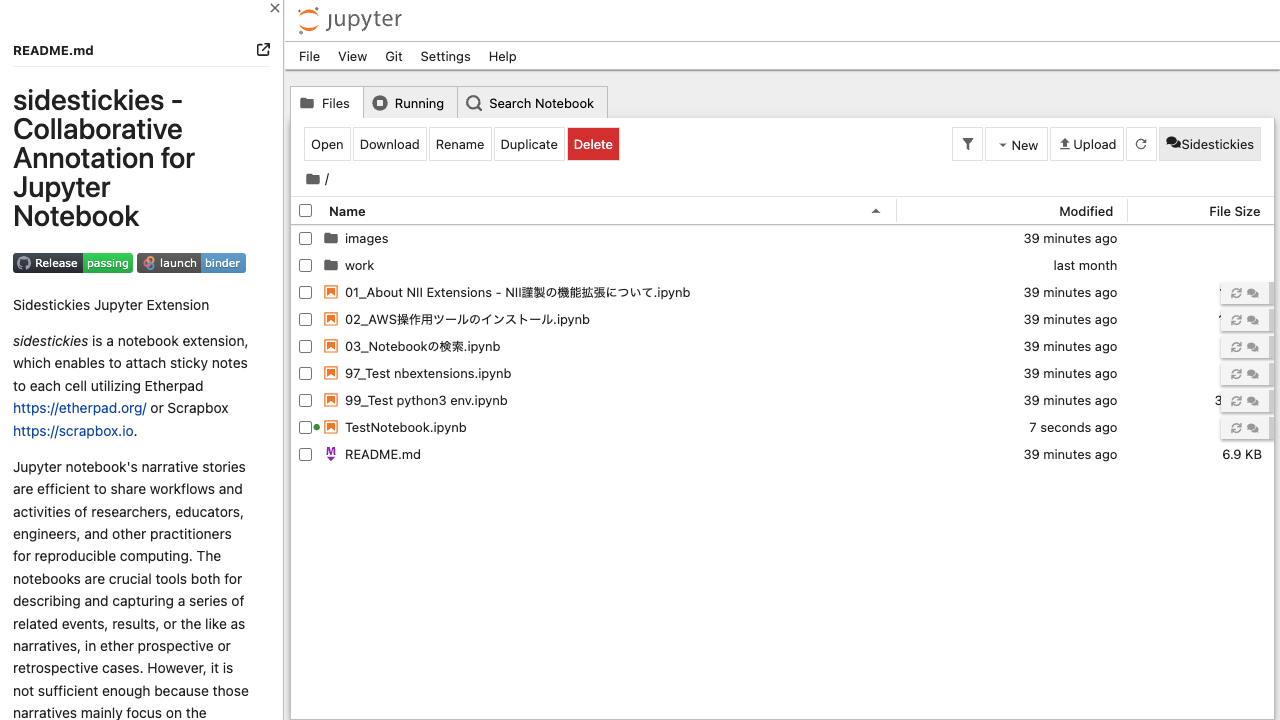

In [90]:
import scripts.sidestickies
importlib.reload(scripts.sidestickies)

async def _step(page):
    # Wait for file to appear in file browser
    await expect(sidestickies.get_file_browser_item_locator(page, test_filename)).to_be_visible(timeout=transition_timeout)
    
    note_locator = sidestickies.get_file_sticky_note_root_locator(page, test_filename).locator('.nbtags-tag')
    await expect(note_locator).to_be_visible(timeout=transition_timeout)
    
    # Verify the tag has expected structure (refresh icon and comments icon)
    await expect(note_locator.locator('.fa-refresh')).to_be_visible()
    await expect(note_locator.locator('.fa-comments')).to_be_visible()

    print("Notebook tag widgets display correctly on .ipynb files")

await run_pw(_step)

## Open new sticky note for the notebook file

Start epoch: 1762125090.083895 seconds


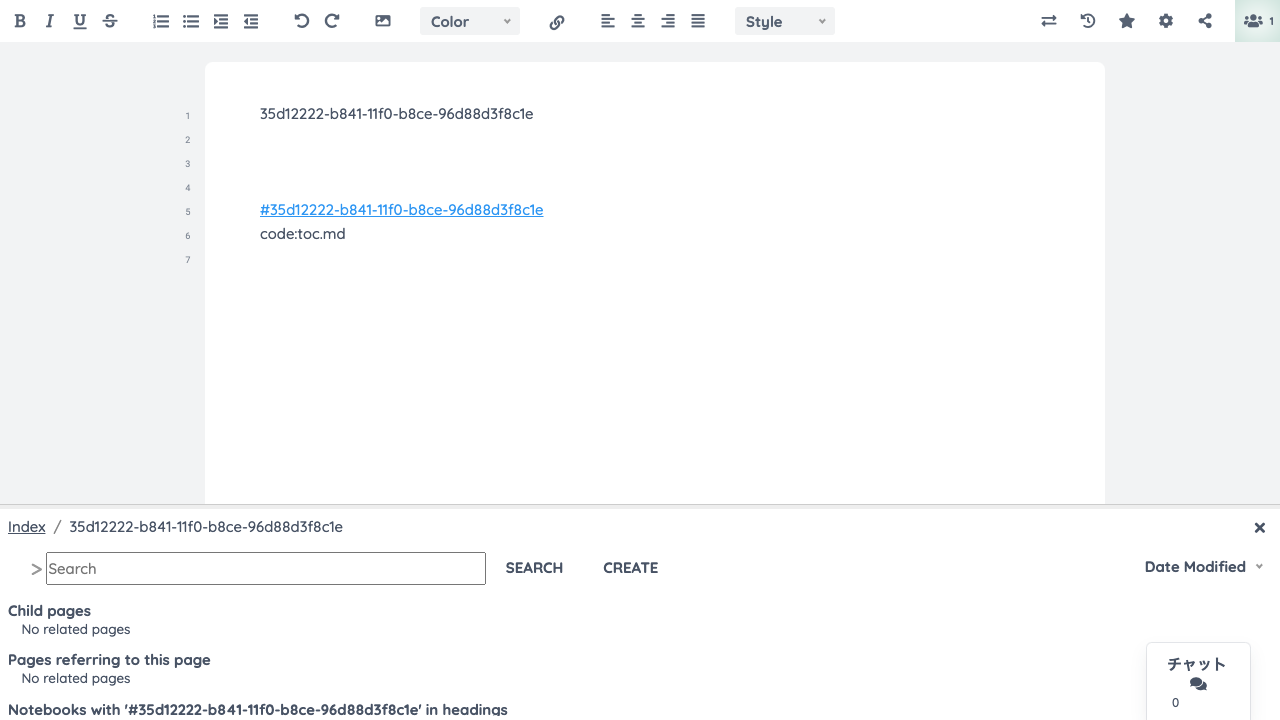

In [91]:
import re

async def _step(page):
    # Wait for a new window to open
    popup_future = page.wait_for_event('popup')
    await sidestickies.get_file_sticky_note_root_locator(page, test_filename).locator('.fa-comments').click()
    popup = await popup_future

    await expect(popup.locator('//iframe[@name="ace_outer"]')).to_be_visible(timeout=transition_timeout)

    return popup

await run_pw(_step)

## Change the title of the sticky note pad

Start epoch: 1762125090.717504 seconds


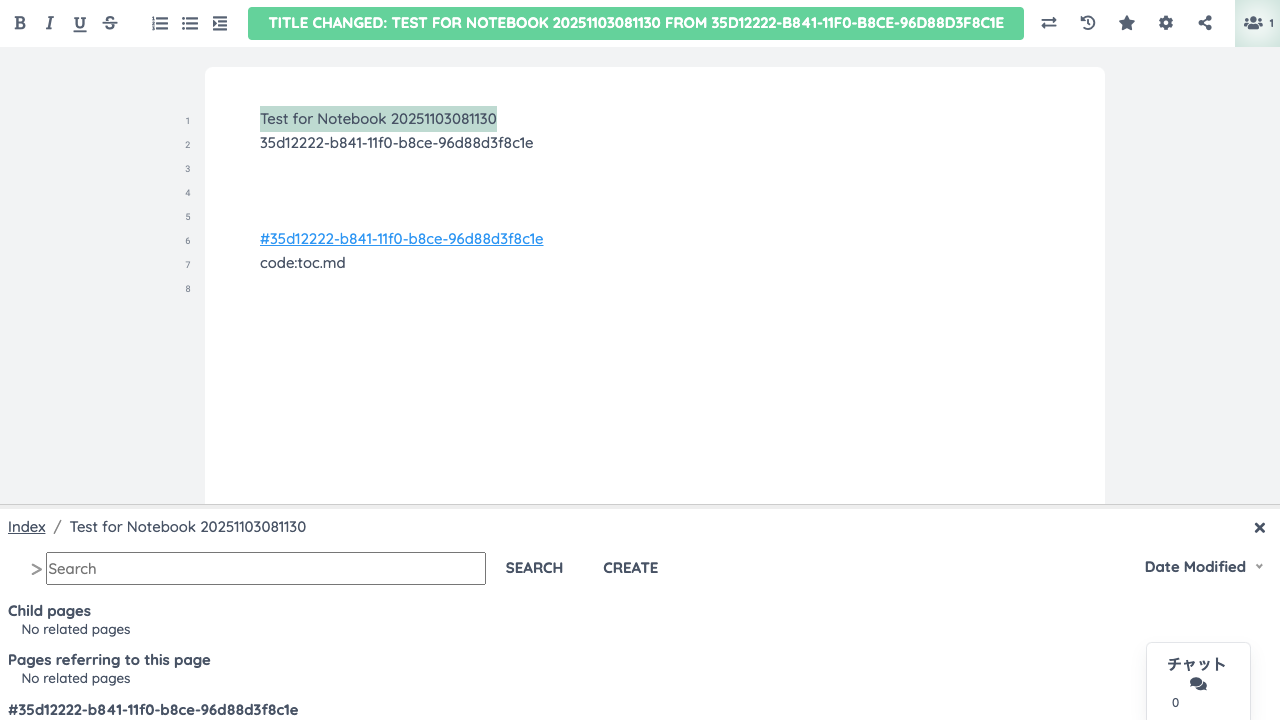

In [92]:
from datetime import datetime
import re

async def extract_ace_inner_docbody(page):
    iframe_locator = page.frame_locator('iframe[name="ace_outer"]').frame_locator('iframe[name="ace_inner"]')
    await expect(iframe_locator.locator('#innerdocbody')).to_be_visible(timeout=transition_timeout)
    return iframe_locator.locator('#innerdocbody')

notebook_pad_title = f"Test for Notebook {datetime.now().strftime('%Y%m%d%H%M%S')}"

async def _step(page):
    inner_docbody = await extract_ace_inner_docbody(page)
    await inner_docbody.focus()

    await inner_docbody.type(notebook_pad_title, delay=100)
    await inner_docbody.press("Enter")

    await page.wait_for_load_state('networkidle')
    await asyncio.sleep(1)  # Wait a moment to ensure the title change is processed
    await expect(page).to_have_title(re.compile(f"^{notebook_pad_title}"), timeout=transition_timeout)

await run_pw(_step)

## Close the pad window and refresh the sticky note widget

Start epoch: 1762125096.010462 seconds


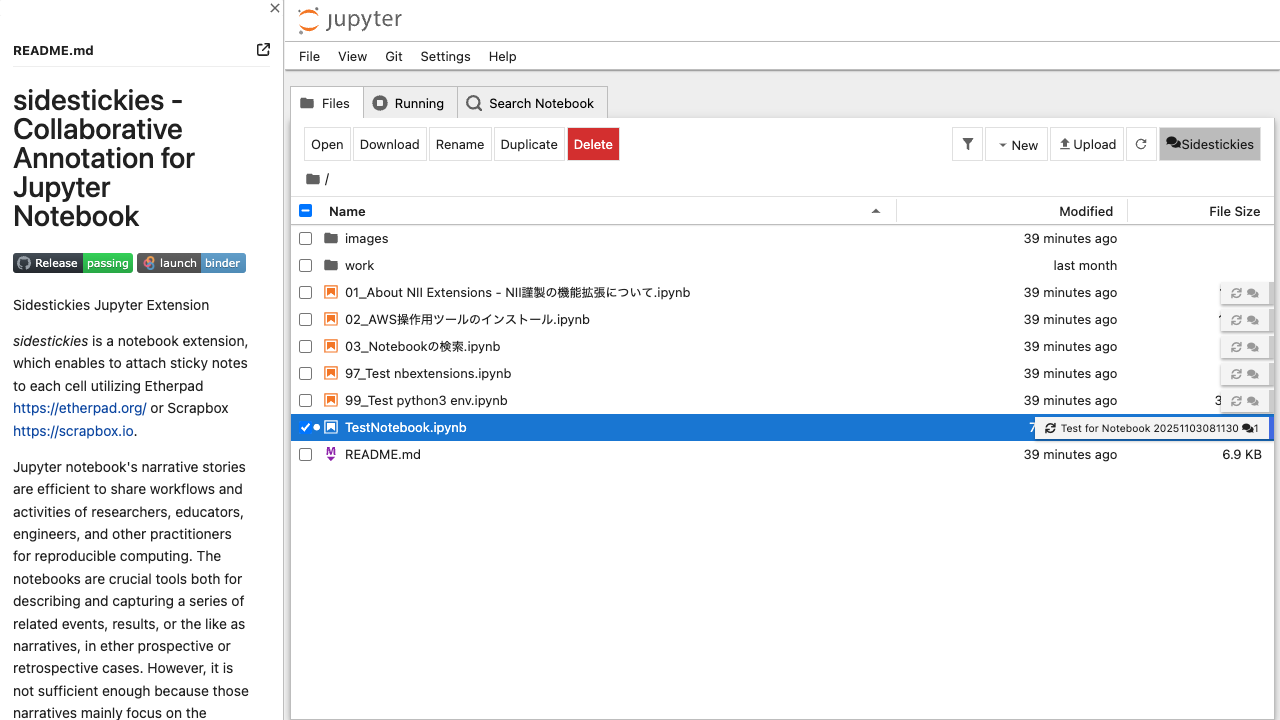

In [93]:
async def _step(page):
    cell = sidestickies.get_file_sticky_note_root_locator(page, test_filename)
    await cell.locator('.fa-refresh').click()

    await expect(cell.locator('.item_name')).to_have_text(re.compile(notebook_pad_title), timeout=transition_timeout)

await close_latest_page()
await run_pw(_step)

## Toggle sidestickies off and verify tags disappear

Start epoch: 1762125096.465605 seconds
Tag count after disabling: 0
Sidestickies successfully disabled in file browser


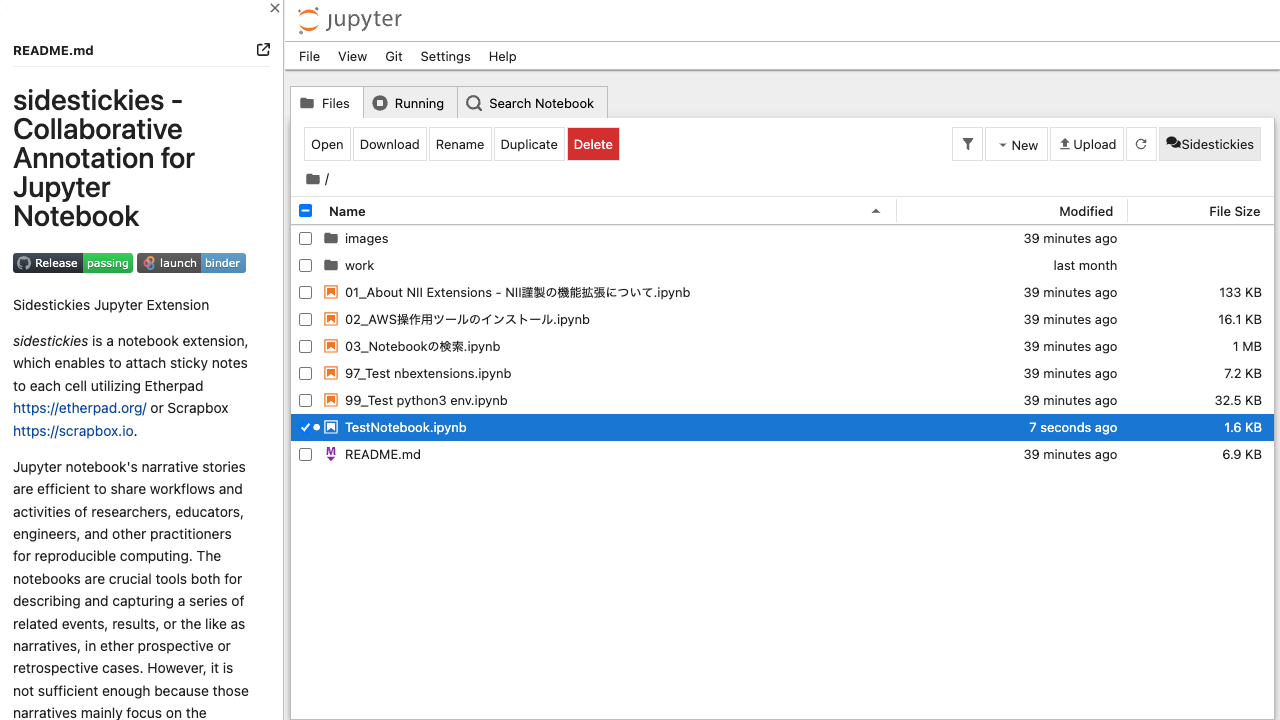

In [94]:
async def _step(page):
    toggle_button = page.locator('.jp-FileBrowser .sidestickies-comment-toggle')

    # Click the toggle button again to disable
    await toggle_button.click()
    await asyncio.sleep(0.5)
    
    # Verify the active state indicator is no longer visible
    await expect(toggle_button.locator('.sidestickies-comment-visible')).not_to_be_visible()
    
    # Verify that tag widgets are no longer visible
    tag_elements = page.locator('li.jp-DirListing-item .nbtags-tag')
    tag_count = await tag_elements.count()
    
    print(f"Tag count after disabling: {tag_count}")
    assert tag_count == 0, "Notebook tag widgets should not be visible when sidestickies is disabled"
    
    print("Sidestickies successfully disabled in file browser")

await run_pw(_step)

## Clean up

In [95]:
await finish_pw_context()

Video: /var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpxp_zx_f6/video-1.webm
HAR: /var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpxp_zx_f6/har.zip


スクリーンキャプチャ動画の取得に失敗しました。
Traceback (most recent call last):
  File "/Users/yazawa/workspace/nii-cloud/sidestickies/ui-tests/e2e-notebook/notebooks/scripts/playwright.py", line 208, in _finish_pw_context
    shutil.copyfile(video_path, dest_video_path)
  File "/Users/yazawa/.pyenv/versions/3.11.5/lib/python3.11/shutil.py", line 256, in copyfile
    with open(src, 'rb') as fsrc:
         ^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpmwyyeo5e/videos/927f5cbd9710fe6b3ca79a035698cd4b.webm'


In [96]:
!rm -fr {work_dir}